In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import matplotlib.image as mpi
import json

from contrastive.utils.config import get_config_diff

In [2]:
path = "/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet"
get_config_diff(path)

## Resume the results

In [52]:
def exclude_conditions(diff_config, excluded_conditions):
    excluded_subdirs = []
    for cond in excluded_conditions:
        filtered_diff_config = diff_config.query(cond)
        excluded_subdirs.extend(filtered_diff_config['Unnamed: 0'].values)
    return excluded_subdirs

dir_path = "/home/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Output/supervised/densenet"
diff_config = pd.read_csv(dir_path+'/config_diff.csv')
diff_config

#exclude_conditions(diff_config, excluded_conditions=["lr != 0.0004"])

,Unnamed: 0,drop_rate,early_stopping_patience,max_epochs,temperature,temperature_initial,train_val_csv_file,backbone_name
0,tau-0.1_drop-0.0,0.00,250,300,0.1,0.1,/neurospin/dico/data/deep_folding/current/data...,NaN
1,tau-0.1_drop-0.1,0.10,250,300,0.1,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
2,tau-0.5_drop-0.0,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
3,tau-0.5_drop-0.0_2,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
4,tau-0.5_drop-0.0_3,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
5,tau-0.5_drop-0.0_percentage-variable,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
6,tau-0.5_drop-0.1,0.10,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
7,tau-0.5_drop-0.15,0.15,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
8,tau-0.5_drop-0.15_percentage-variable-75,0.15,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
9,tau-0.5_drop-0.15_percentage-variable-75_2,0.15,100,301,0.5,0.5,NaN,densenet


In [53]:
def show_results(dir_path, figsize=(16,10), return_config_diff=False, excluded_conditions=[]):
    # be sure that all models are comparable
    get_config_diff(dir_path, whole_config=False)
    diff_config = pd.read_csv(dir_path+'/config_diff.csv')

    excluded_subdirs = exclude_conditions(diff_config, excluded_conditions)
    if excluded_conditions != []:
        print("Excluded subdirs :", excluded_subdirs)
        print("Excluded because of ", excluded_conditions)

    print(diff_config[~diff_config['Unnamed: 0'].isin(excluded_subdirs)])

    paths = []
    accuracy = []
    accuracy_std = []
    auc = []
    auc_std = []
    # plot all ROC curves
    for subdir in os.listdir(dir_path):
        if os.path.isdir(dir_path + '/' + subdir) and subdir not in excluded_subdirs:
            path = dir_path + '/' + subdir + '/cingulate_ACCpatterns_embeddings'
            with open(path+'/values.json', 'r') as file:
                values = json.load(file)
            print(subdir)
            print("AUC", values['cross_val_auc'])
            img = mpi.imread(path+'/cross_val_ROC_curves.png')
            plt.figure(figsize=figsize)
            plt.imshow(img)
            plt.show()

            # store the AUC and accuracy in a df
            paths.append(subdir)
            accuracy.append(values['cross_val_total_accuracy'][0])
            accuracy_std.append(values['cross_val_total_accuracy'][1])
            auc.append(values['cross_val_auc'][0])
            auc_std.append(values['cross_val_auc'][1])

    results_df = pd.DataFrame()
    results_df['path'] = paths
    results_df['auc'] = auc
    results_df['auc_std'] = auc_std
    results_df['accuracy'] = accuracy
    results_df['accuracy_std'] = accuracy_std


    if return_config_diff:
        return results_df, diff_config
    else:
        return results_df

               Unnamed: 0 backbone_name block_config  foldlabel  growth_rate  \
0                09-28-35      densenet      [6, 16]       True         32.0   
1                09-29-08      densenet      [6, 16]       True         32.0   
2                11-05-29      densenet      [6, 16]       True         32.0   
3                11-05-34      densenet      [6, 16]       True         32.0   
4                12-18-43      densenet      [6, 16]      False         32.0   
5                12-19-16      densenet      [6, 16]      False         32.0   
6    convnet_sigmoid_fold       convnet          NaN       True          NaN   
7      convnet_sigmoid_no       convnet          NaN      False          NaN   
8   densenet_sigmoid_fold      densenet      [6, 16]       True         32.0   
9     densenet_sigmoid_no      densenet      [6, 16]      False         32.0   
10  pointnet_sigmoid_fold      pointnet          NaN       True          NaN   
11    pointnet_sigmoid_no      pointnet 

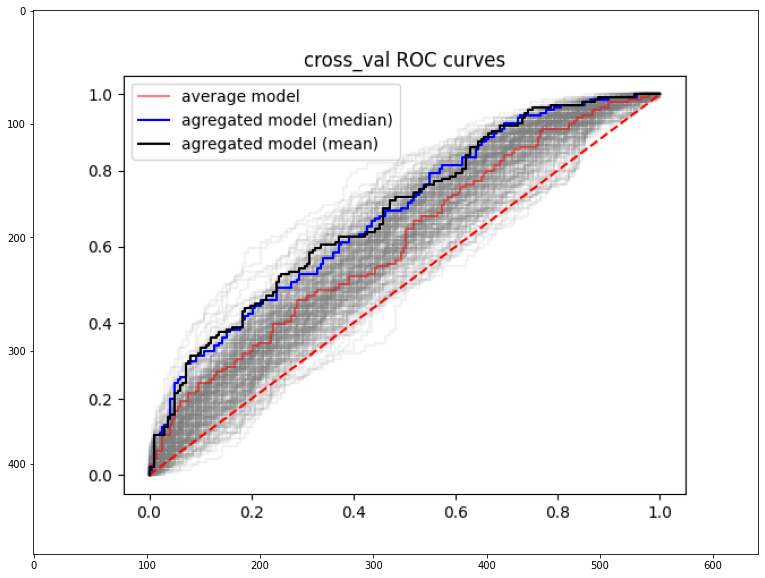

09-29-08
AUC [0.6709138465877044, 0.051651965352005336]


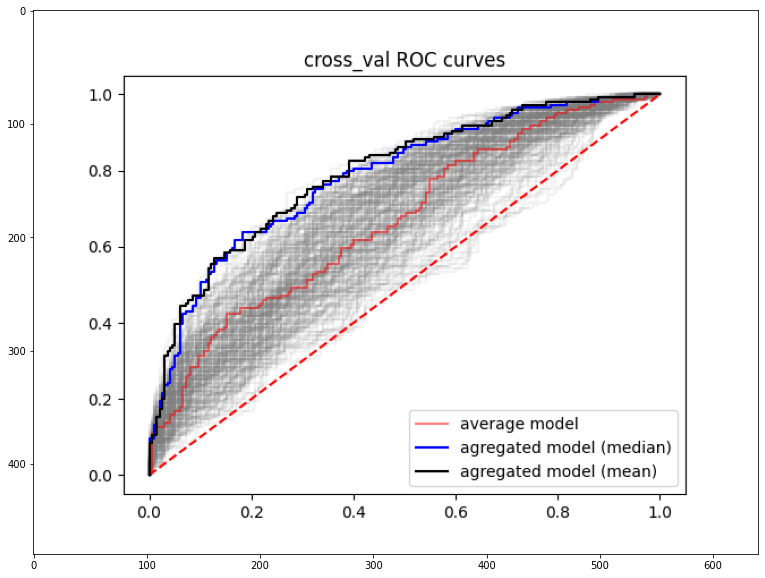

convnet_sigmoid_fold
AUC [0.6058815566835872, 0.04292018577945286]


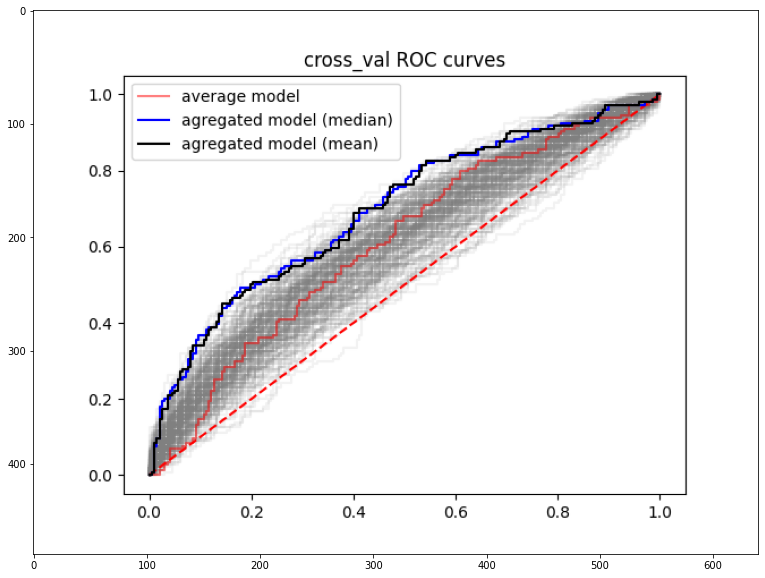

09-28-35
AUC [0.6935901015228427, 0.05183104224280027]


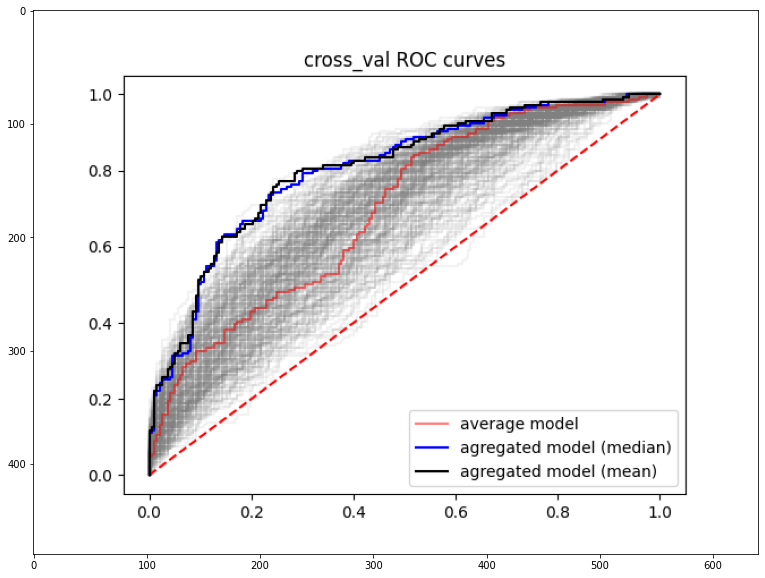

densenet_sigmoid_fold
AUC [0.6567935702199661, 0.024040189454447032]


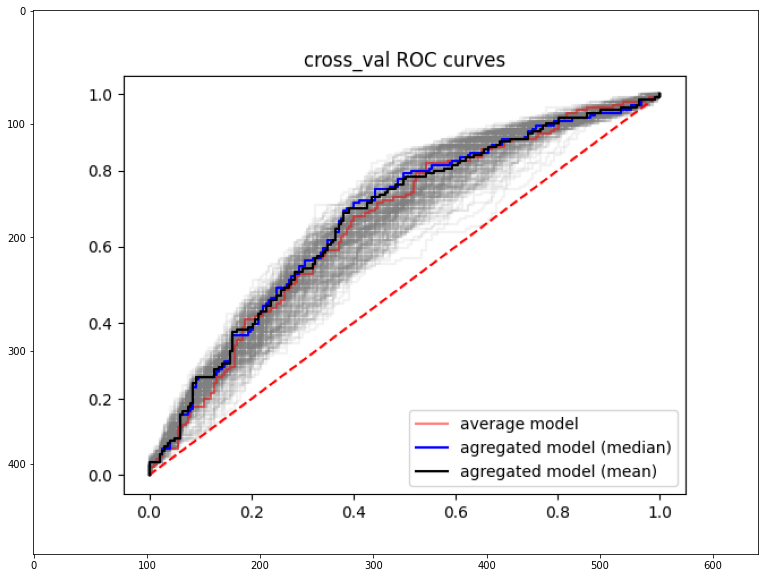

12-18-43
AUC [0.556313733784546, 0.03140198782408546]


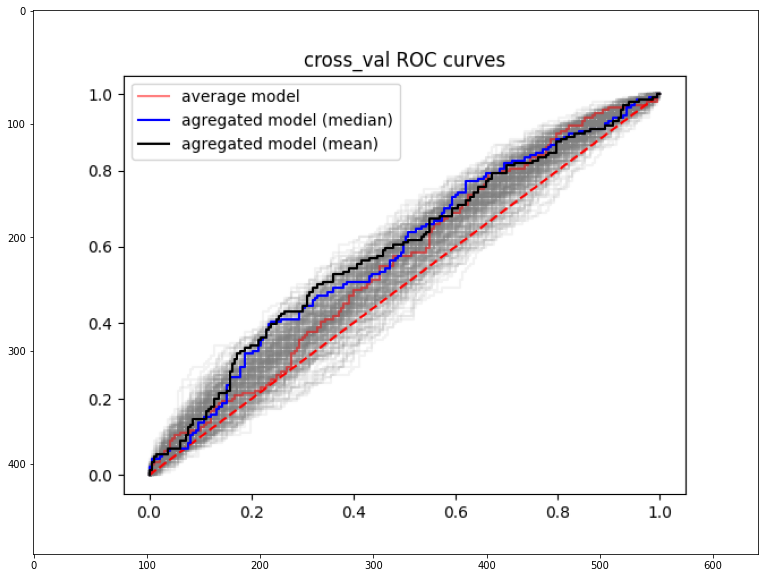

convnet_sigmoid_no
AUC [0.6540270727580372, 0.044209963430391803]


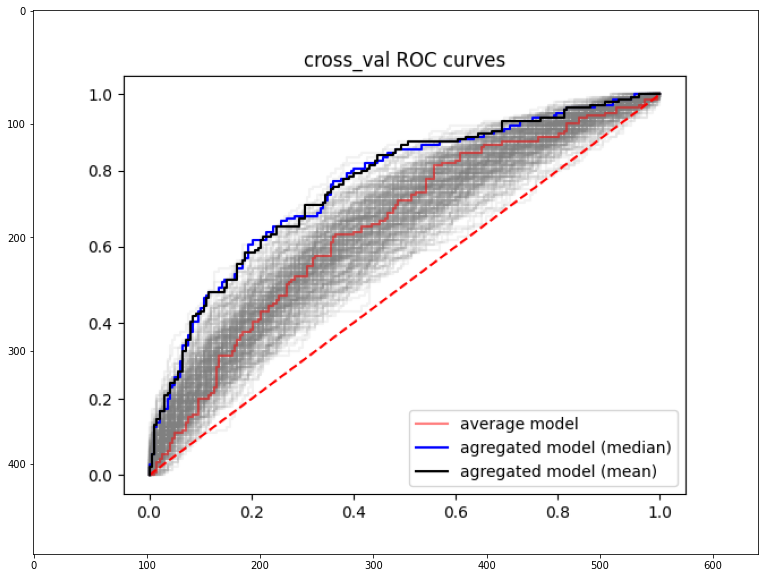

12-19-16
AUC [0.5411112521150592, 0.034453869959404804]


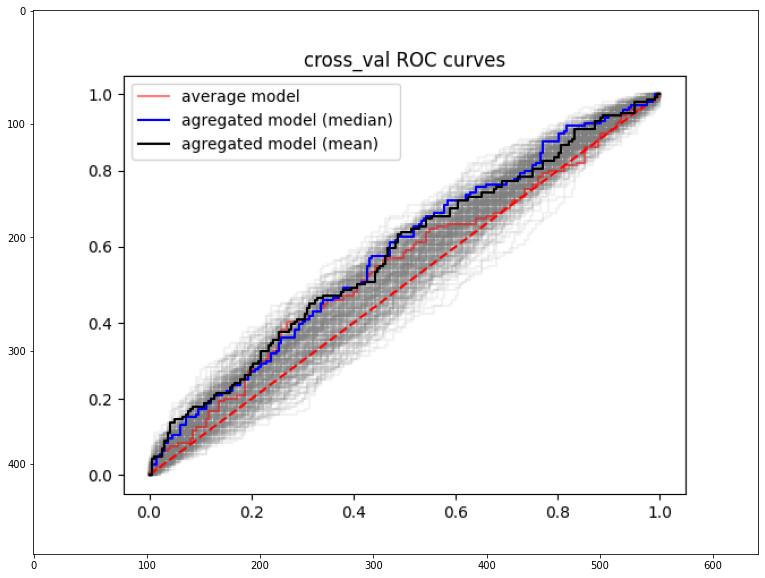

densenet_sigmoid_no
AUC [0.5252963902989284, 0.007671371464535259]


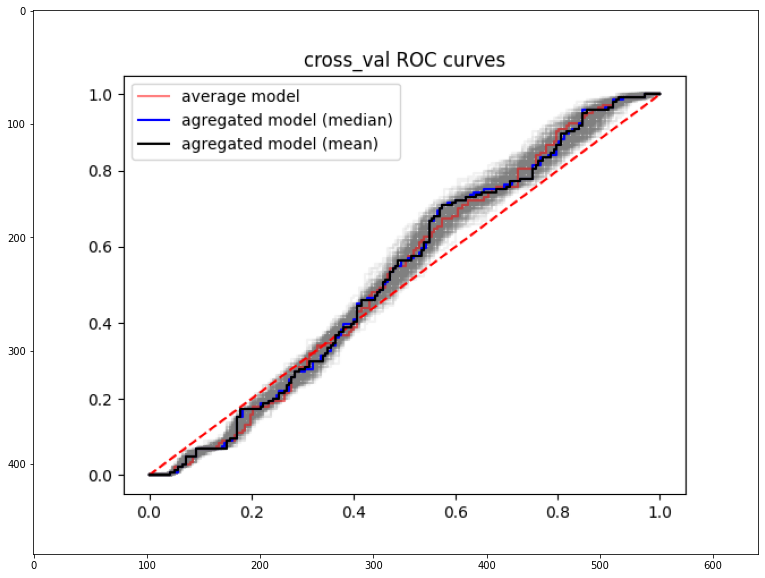

pointnet_sigmoid_no
AUC [0.6334459954878737, 0.009113544567397975]


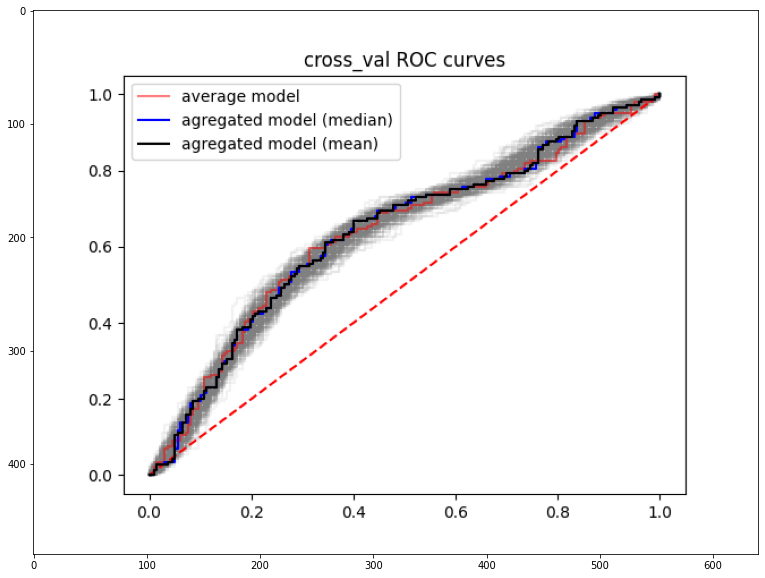

pointnet_sigmoid_fold
AUC [0.6768902989283699, 0.006476536306712138]


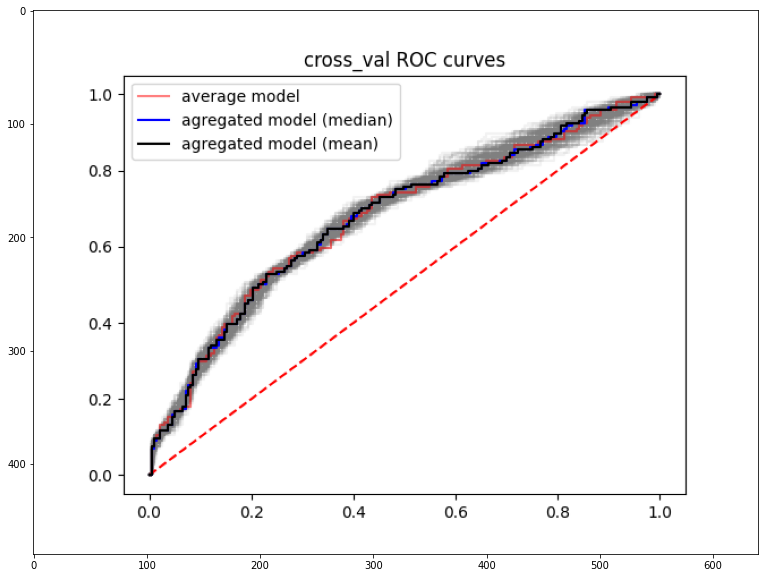

11-05-34
AUC [0.6681613085166385, 0.050466405216429575]


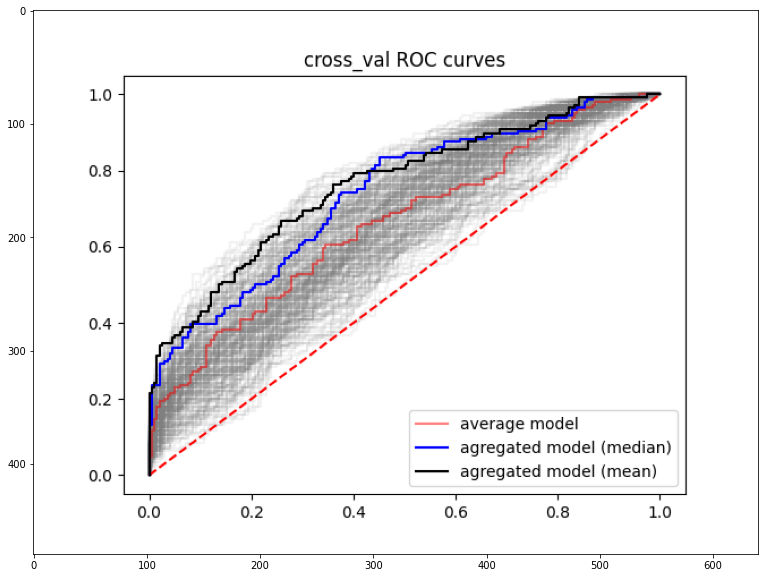

,path,auc,auc_std,accuracy,accuracy_std
0,11-05-29,0.611789,0.046256,0.564434,0.048428
1,09-29-08,0.670914,0.051652,0.596364,0.056285
2,convnet_sigmoid_fold,0.605882,0.042920,0.590628,0.033440
3,09-28-35,0.693590,0.051831,0.619449,0.052646
4,densenet_sigmoid_fold,0.656794,0.024040,0.619226,0.023931
5,12-18-43,0.556314,0.031402,0.540680,0.033677
6,convnet_sigmoid_no,0.654027,0.044210,0.617419,0.034154
7,12-19-16,0.541111,0.034454,0.536223,0.032157
8,densenet_sigmoid_no,0.525296,0.007671,0.529525,0.007129
9,pointnet_sigmoid_no,0.633446,0.009114,0.632540,0.010598


In [55]:
excluded_conditions = []

results_df = show_results("/neurospin/dico/agaudin/Runs/04_pointnet/Output/2022-09-02",
excluded_conditions=excluded_conditions)

results_df

In [56]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
3,09-28-35,0.693590
10,pointnet_sigmoid_fold,0.676890
1,09-29-08,0.670914
11,11-05-34,0.668161
4,densenet_sigmoid_fold,0.656794


                                    Unnamed: 0  drop_rate  \
0                             tau-0.1_drop-0.0       0.00   
1                             tau-0.1_drop-0.1       0.10   
2                             tau-0.5_drop-0.0       0.00   
3                           tau-0.5_drop-0.0_2       0.00   
4                           tau-0.5_drop-0.0_3       0.00   
5         tau-0.5_drop-0.0_percentage-variable       0.00   
6                             tau-0.5_drop-0.1       0.10   
7                            tau-0.5_drop-0.15       0.15   
8     tau-0.5_drop-0.15_percentage-variable-75       0.15   
9   tau-0.5_drop-0.15_percentage-variable-75_2       0.15   
10                          tau-0.5_drop-0.1_2       0.10   
11            tau-0.5_drop-0.2_drop-output-0.0       0.20   
12            tau-0.5_drop-0.2_drop-output-0.1       0.20   

    early_stopping_patience  max_epochs  temperature  temperature_initial  \
0                       250         300          0.1                

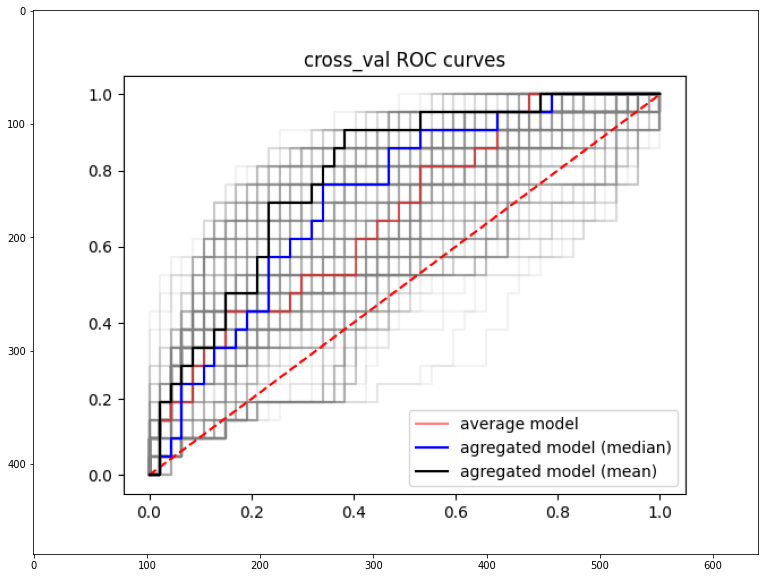

tau-0.1_drop-0.1
AUC [0.5578399189463018, 0.06382768250498178]


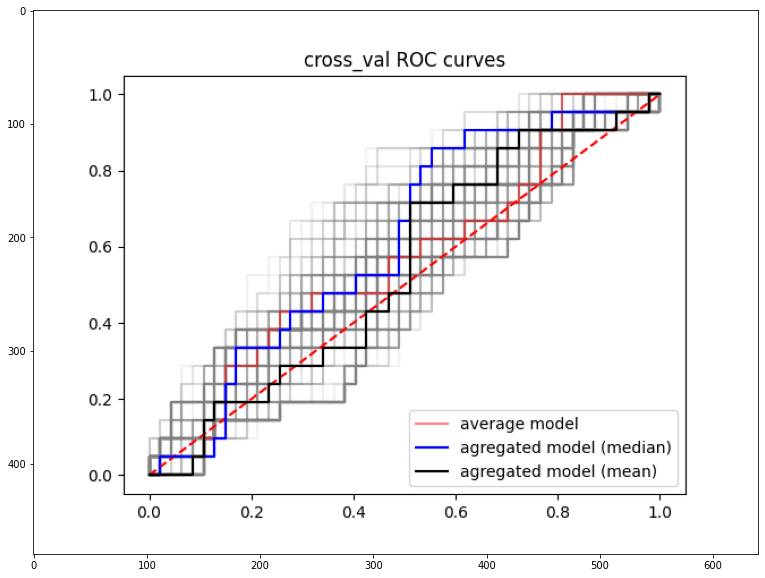

tau-0.5_drop-0.0_3
AUC [0.7904275582573455, 0.08015607895434278]


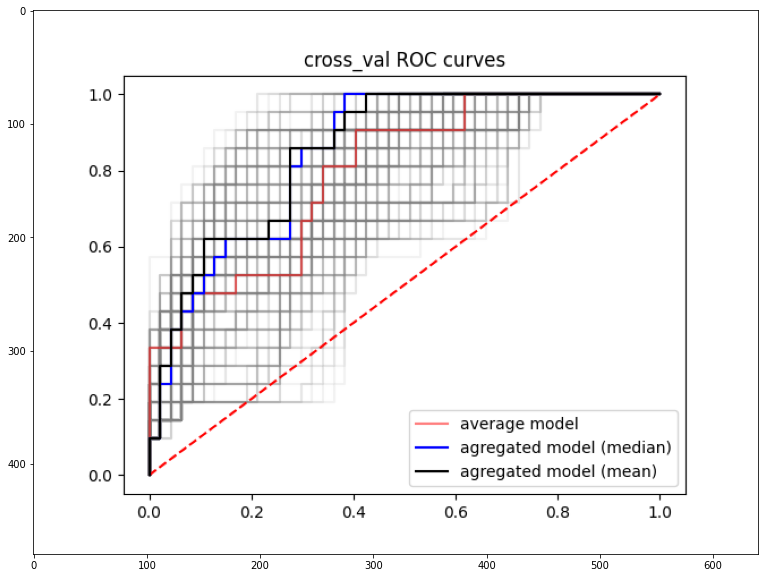

tau-0.5_drop-0.1
AUC [0.6520567375886525, 0.10145402908193465]


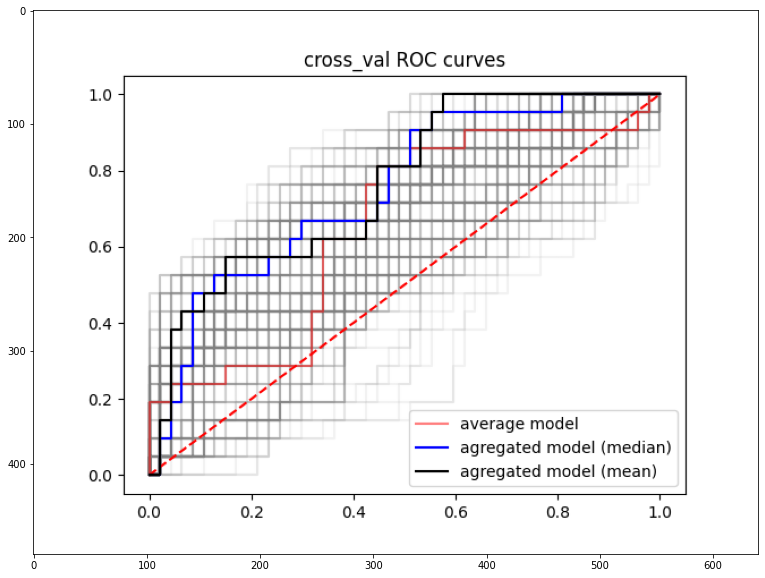

tau-0.5_drop-0.2_drop-output-0.1
AUC [0.6923606889564337, 0.07886553978647642]


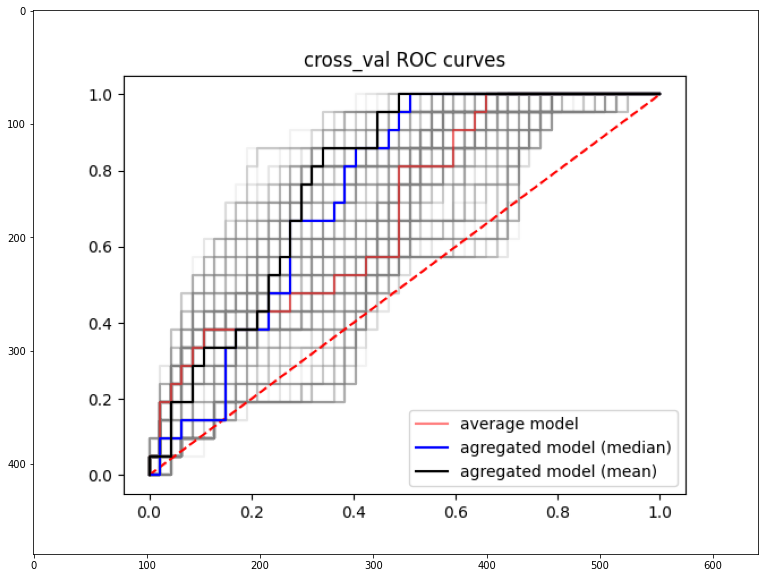

tau-0.5_drop-0.2_drop-output-0.0
AUC [0.7259777102330294, 0.08000158338515732]


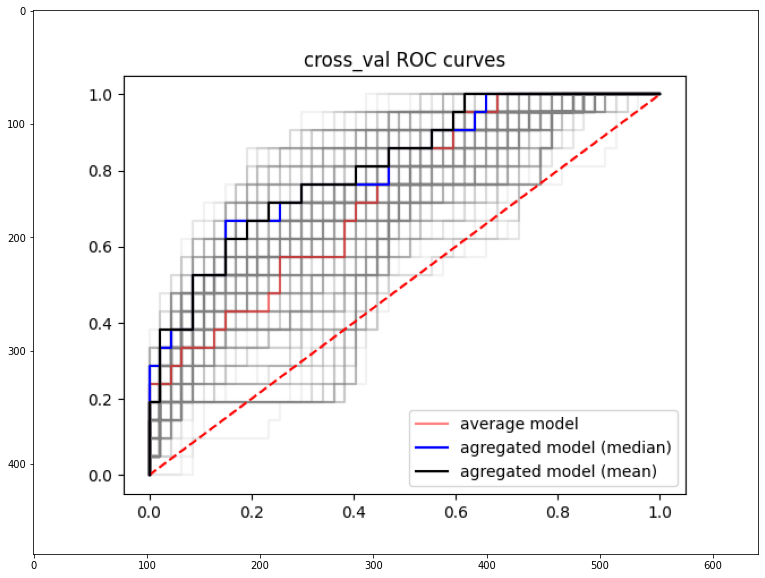

FileNotFoundError: [Errno 2] No such file or directory: '/home/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Output/supervised/densenet/tau-0.5_drop-0.15_percentage-variable-75_2/cingulate_ACCpatterns_embeddings/values.json'

In [11]:
excluded_conditions = []

results_df = show_results("/home/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Output/supervised/densenet",
excluded_conditions=excluded_conditions)

results_df

In [12]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
0,without-forcing_foldabel_1,0.541490
1,without-forcing_foldabel_2,0.514956


/volatile/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Program/2022_jchavas_cingulate_inhibitory_control/contrastive/utils/config.py:123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  global_df = pd.concat([global_df, config_df], axis=0)


                                          Unnamed: 0 backbone_name  drop_rate  \
0            tau-0.5_drop-0.0_percentage-variable-75       convnet       0.00   
1          tau-0.5_drop-0.15_cutout_backbone-convnet           NaN       0.15   
2  tau-0.5_drop-0.15_percentage-variable-75_backb...           NaN       0.15   
3  tau-0.5_drop-0.15_percentage-variable-75_backb...       convnet       0.15   
4  tau-0.5_drop-0.25_percentage-variable-75_backb...           NaN       0.25   
5  tau-0.5_drop-0.2_percentage-variable-75_backbo...           NaN       0.15   
6  tau-0.5_drop-0.3_percentage-variable-75_backbo...           NaN       0.30   

   early_stopping_patience  foldlabel  max_angle      patch_size  \
0                      100       True          6             NaN   
1                      250      False         10  [1, 9, 22, 21]   
2                      250       True          6             NaN   
3                      100       True          6             NaN   
4          

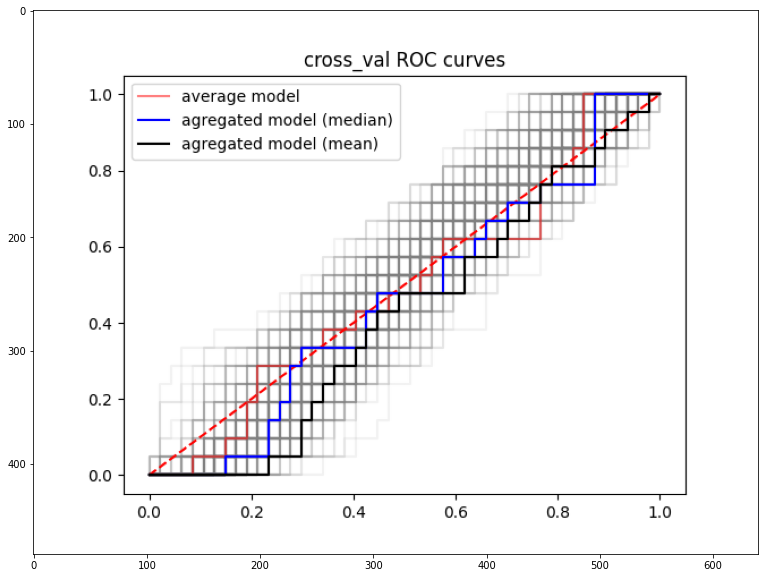

tau-0.5_drop-0.0_percentage-variable-75
AUC [0.5627720364741642, 0.09388947962022412]


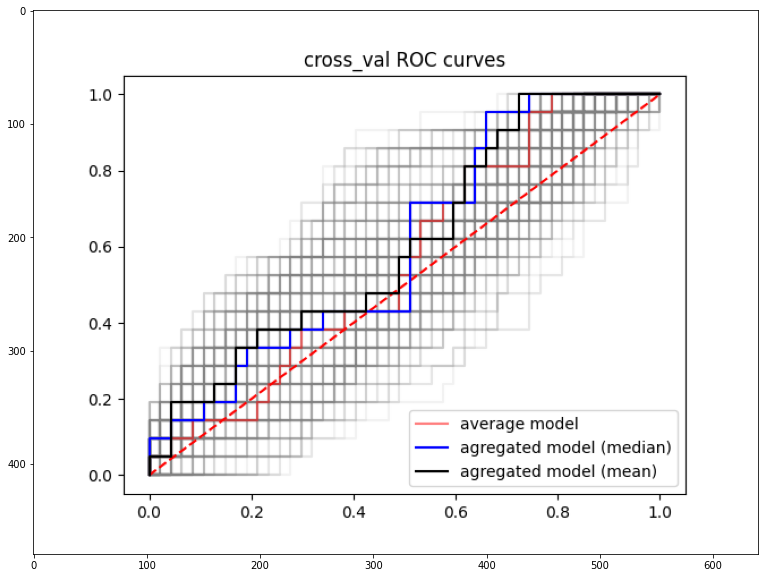

tau-0.5_drop-0.15_cutout_backbone-convnet
AUC [0.5149138804457952, 0.08362887145886067]


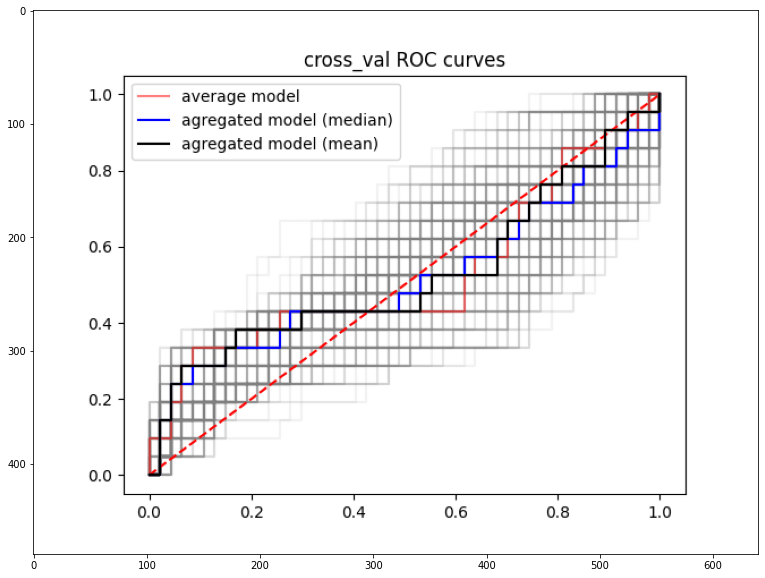

tau-0.5_drop-0.25_percentage-variable-75_backbone-convnet
AUC [0.36738804457953395, 0.10796514149720135]


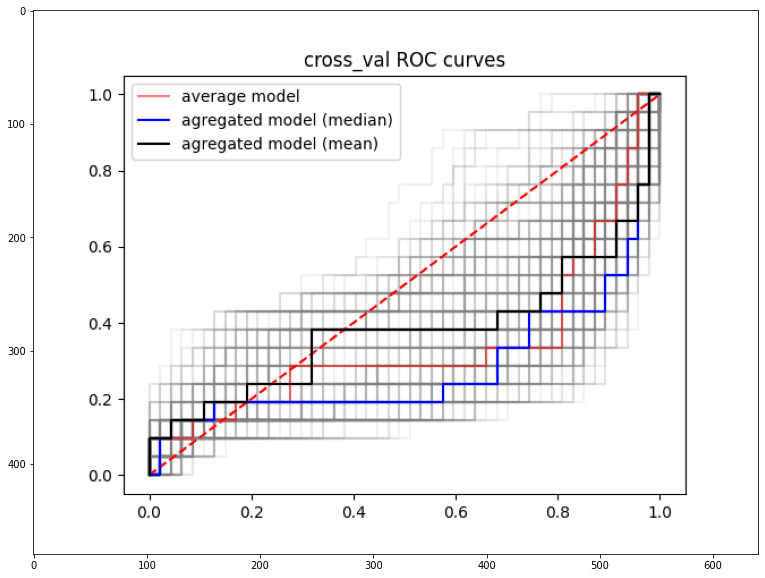

tau-0.5_drop-0.15_percentage-variable-75_backbone-convnet_2
AUC [0.481531914893617, 0.04646467770058261]


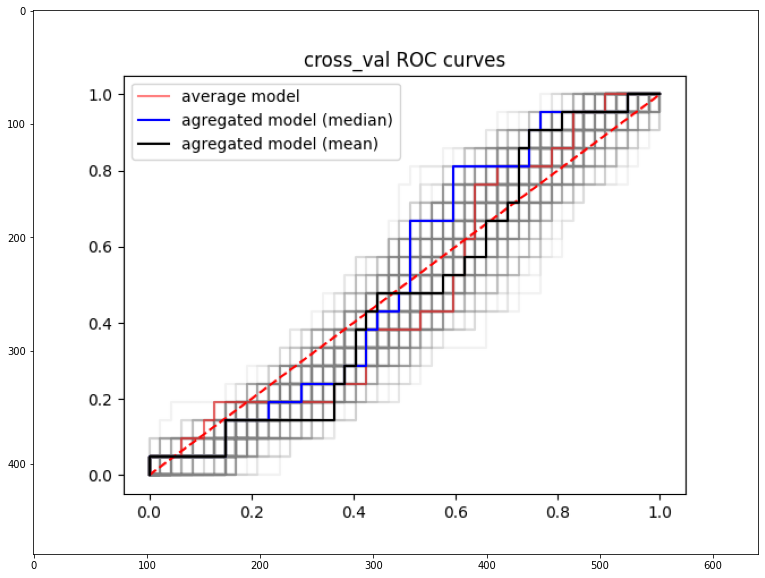

tau-0.5_drop-0.2_percentage-variable-75_backbone-convnet
AUC [0.508838905775076, 0.05888613419413187]


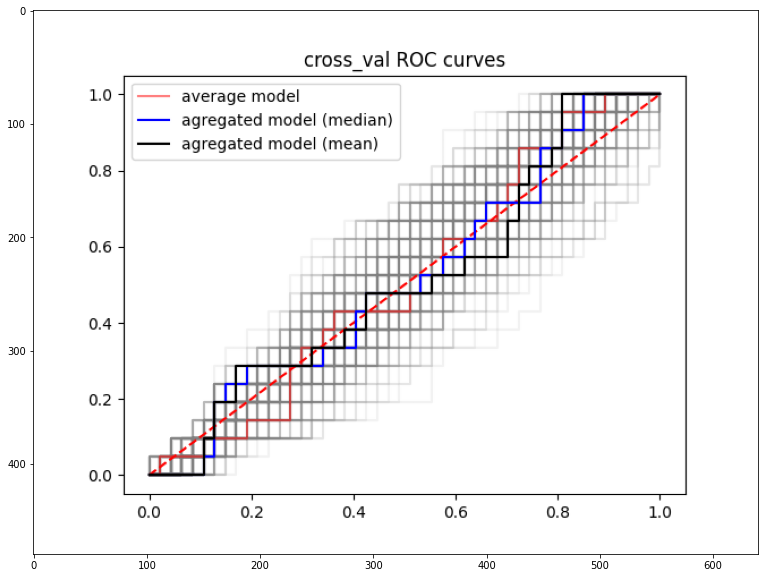

tau-0.5_drop-0.15_percentage-variable-75_backbone-convnet
AUC [0.5013171225937183, 0.061914561197816353]


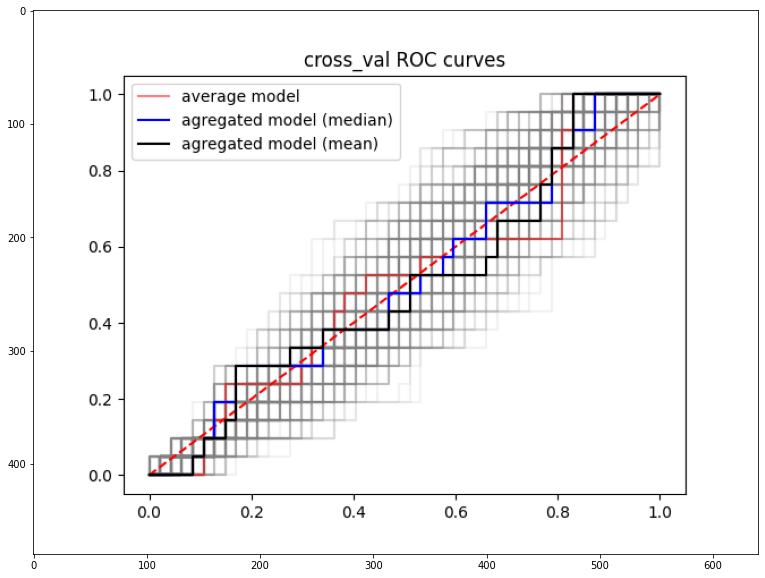

path       auc   auc_std  \
0  tau-0.5_drop-0.3_percentage-variable-75_backbo...  0.494890  0.061100   
1            tau-0.5_drop-0.0_percentage-variable-75  0.562772  0.093889   
2          tau-0.5_drop-0.15_cutout_backbone-convnet  0.514914  0.083629   
3  tau-0.5_drop-0.25_percentage-variable-75_backb...  0.367388  0.107965   
4  tau-0.5_drop-0.15_percentage-variable-75_backb...  0.481532  0.046465   
5  tau-0.5_drop-0.2_percentage-variable-75_backbo...  0.508839  0.058886   
6  tau-0.5_drop-0.15_percentage-variable-75_backb...  0.501317  0.061915   

   accuracy  accuracy_std  
0  0.684294      0.014595  
1  0.640824      0.077700  
2  0.691529      0.030021  
3  0.671471      0.029501  
4  0.613353      0.054943  
5  0.617941      0.040721  
6  0.614294      0.038348

In [19]:
excluded_conditions = []

results_df = show_results("/home/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Output/supervised/convnet",
excluded_conditions=excluded_conditions)

results_df

In [20]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
9,pointnet_sigmoid_no,0.633446
0,11-05-29,0.611789
2,convnet_sigmoid_fold,0.605882
5,12-18-43,0.556314
7,12-19-16,0.541111
8,densenet_sigmoid_no,0.525296
4,tau-0.5_drop-0.15_percentage-variable-75_backb...,0.481532
3,tau-0.5_drop-0.25_percentage-variable-75_backb...,0.367388


In [ ]:
excluded_conditions = []

results_df = show_results("/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/supervised/acc/aymeric",
excluded_conditions=excluded_conditions)

results_df

In [22]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

path       auc
2                 lr=0.0008  0.564815
1  non_supervised_lr=0.0008  0.555703
0                 lr=0.0004  0.532388

In [ ]:
# convnet exploration
excluded_conditions = []

results_df = show_results("/neurospin/dico/agaudin/Runs/03_monkeys/Output/convnet_exploration",
excluded_conditions=excluded_conditions)

results_df

In [8]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
11,base1,0.673959
2,T_1,0.655674
10,drop_rate_0,0.654164
9,base2,0.648114
14,base3,0.644770
5,batch_size_64,0.636690
8,T_0.01,0.626335
4,T_0.5,0.624267
7,batch_size_4,0.617623
3,drop_rate_0.3,0.609882


In [11]:
# directories are supposed to have a certain structure and name patterns
def get_results_table(dir_path, model_types=['convnet', 'densenet2'], verbose=False):
    results = {k: {} for k in model_types}

    for model_type in os.listdir(dir_path):
        if model_type in model_types:
            if verbose:
                print(model_type)
            path = os.path.join(dir_path, model_type)
            for params in os.listdir(path):
                params_path = os.path.join(path, params)
                if os.path.isdir(params_path):
                    if verbose:
                        print(params)
                    
                    n_models = 0

                    if model_type == 'pca':
                        results[model_type]['foldlabel_'+params] = 0
                        results[model_type]['no_foldlabel_'+params] = 0
                    else:    
                        results[model_type][params] = 0
                    
                    for model in os.listdir(params_path):
                        model_path = os.path.join(params_path, model)
                        # start a model name by & to filter it out of the performance analysis
                        if os.path.isdir(model_path) and model[0] != '&':
                            if verbose:
                                print(model)

                            n_models += 1

                            if model_type == 'pca':
                                values = os.path.join(params_path, model, 'values.json')
                                with open(values, 'r') as file:
                                    values = json.load(file)
                                results[model_type]['foldlabel_'+params] += values['cross_val_auc'][0]
                                results[model_type]['no_foldlabel_'+params] += values['cross_val_auc'][0]
                            else:
                                values = os.path.join(params_path, model, 'cingulate_ACCpatterns_embeddings/values.json')
                                with open(values, 'r') as file:
                                    values = json.load(file)
                                results[model_type][params] += values['cross_val_auc'][0]
                    
                    if model_type == 'pca':
                        results[model_type]['foldlabel_'+params] = results[model_type]['foldlabel_'+params]/n_models
                        results[model_type]['no_foldlabel_'+params] = results[model_type]['no_foldlabel_'+params]/n_models
                    else:
                        results[model_type][params] = results[model_type][params]/n_models
    
    results_df = pd.DataFrame(results)
    results_df.sort_index(inplace=True)
    return results_df

In [12]:
dir_path = "/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders"
results_df = get_results_table(dir_path, model_types=['convnet', 'densenet2', 'pca'])

results_df.to_csv("/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/performance_comparison_5000.csv")

results_df

,convnet,densenet2,pca
foldlabel_30,0.613729,0.658608,0.593625
foldlabel_4,0.589703,0.574395,0.538784
no_foldlabel_30,0.649748,0.575910,0.593625
no_foldlabel_4,0.514435,0.488433,0.538784


## Use the database

In [8]:
bdd = pd.read_csv("/neurospin/dico/agaudin/Runs/new_bdd_models.csv", index_col=0)
bdd

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,max_angle,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,dataset_name,git_branch
0,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.595940,0.045925,0.575977,0.035288,convnet,16,0.15,100,True,...,6,250,30,30,0.1,0.1,0.349243,0.515141,cingulate_HCP_half_1,Run_03_aymeric
1,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.600870,0.040834,0.578182,0.038861,convnet,16,0.15,100,True,...,6,250,30,30,0.1,0.1,0.376334,0.615989,cingulate_HCP_half_1,Run_03_aymeric
2,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.659754,0.048348,0.617584,0.042720,convnet,16,0.15,250,True,...,6,250,30,30,0.1,0.1,0.416473,0.440377,cingulate_HCP_half_1,Run_03_aymeric
3,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.605214,0.042651,0.588129,0.037000,convnet,16,0.15,100,True,...,6,250,30,30,0.1,0.1,0.392093,0.608668,cingulate_HCP_half_1,Run_03_aymeric
4,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.606865,0.044687,0.588305,0.037069,convnet,16,0.15,250,True,...,6,250,30,30,0.1,0.1,0.330082,0.690635,cingulate_HCP_half_1,Run_03_aymeric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.651585,0.001231,0.622804,0.002003,pointnet,16,0.00,100,False,...,10,250,30,30,0.1,0.1,0.890107,0.724653,cingulate_HCP_half_1,pointnet
127,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.627033,0.018632,0.625161,0.012915,pointnet,16,0.10,100,False,...,10,250,30,30,0.1,0.1,1.952606,1.368340,cingulate_HCP_half_1,pointnet
128,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.486872,0.025558,0.577713,0.000000,pointnet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,4.179968,3.784941,cingulate_HCP_half_1,pointnet
129,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.463362,0.009882,0.559331,0.002454,pointnet,16,0.05,100,False,...,10,250,4,4,0.1,0.1,3.744332,3.345133,cingulate_HCP_half_1,pointnet


In [70]:
bdd.columns

Index(['model_path', 'auc', 'auc_std', 'accuracy', 'accuracy_std',
       'backbone_name', 'batch_size', 'drop_rate', 'early_stopping_patience',
       'foldlabel', 'input_size', 'lr', 'max_angle', 'max_epochs',
       'num_outputs', 'num_representation_features', 'temperature',
       'temperature_initial', 'train_loss', 'val_loss', 'dataset_name',
       'git_branch'],
      dtype='object')

In [ ]:
columns_of_interest = ['backbone_name', 'batch_size', 'drop_rate', 'foldlabel', 'lr', 'num_outputs', 'num_representation_features',
'temperature', 'temperature_initial', 'dataset_name']

In [58]:
bdd.sort_values(by='auc', ascending=False, inplace=True)

interesting_columns = ["model_path", 'auc', 'auc_std', 'backbone_name', 'batch_size', 'dataset_name', 'drop_rate', 'foldlabel',
                       'num_representation_features', 'temperature']
bdd[interesting_columns].iloc[:10,:]

,model_path,auc,auc_std,backbone_name,batch_size,dataset_name,drop_rate,foldlabel,num_representation_features,temperature
100,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.5
75,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.693590,0.051831,densenet,16,cingulate_HCP_half_1,0.05,True,30,0.1
25,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.692153,0.049598,densenet,16,cingulate_HCP_half_1,0.15,True,30,0.1
108,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.678702,0.006920,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.1
12,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.678640,0.044072,convnet,16,cingulate_HCP_half_1,0.15,False,30,0.1
103,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.677713,0.000947,pointnet,16,cingulate_HCP_half_1,0.00,True,30,0.1
85,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.676890,0.006477,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.1
97,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.674897,0.015476,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.1
50,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.673959,0.041645,convnet,16,cingulate_HCP_half_1,0.15,False,30,0.1
89,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.672935,0.013104,pointnet,16,cingulate_HCP_full,0.05,True,4,0.5


In [61]:
recent_bdd = bdd[bdd.model_path.str.contains('sigmoid')].sort_values(by='auc', ascending=False)
recent_bdd

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,max_angle,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,dataset_name,git_branch
85,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.676890,0.006477,0.658792,0.007721,pointnet,16,0.05,100,True,...,6,250,30,30,0.1,0.1,1.691467,2.001589,cingulate_HCP_half_1,pointnet
83,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.656794,0.024040,0.619226,0.023931,densenet,16,0.05,100,True,...,6,250,30,30,0.1,0.1,1.431554,3.383259,cingulate_HCP_half_1,Run_03_aymeric
82,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.654027,0.044210,0.617419,0.034154,convnet,16,0.05,100,False,...,10,250,30,30,0.1,0.1,0.133134,0.230621,cingulate_HCP_half_1,Run_03_aymeric
86,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.633446,0.009114,0.632540,0.010598,pointnet,16,0.05,100,False,...,10,250,30,30,0.1,0.1,1.246490,0.742785,cingulate_HCP_half_1,pointnet
81,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.605882,0.042920,0.590628,0.033440,convnet,16,0.05,100,True,...,6,250,30,30,0.1,0.1,0.214677,0.632679,cingulate_HCP_half_1,Run_03_aymeric
84,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.525296,0.007671,0.529525,0.007129,densenet,16,0.05,100,False,...,10,250,30,30,0.1,0.1,0.630446,0.753126,cingulate_HCP_half_1,Run_03_aymeric


In [62]:
bdd[(bdd.model_path.str.contains('04_pointnet')) & (bdd.backbone_name == 'convnet')]

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,max_angle,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,dataset_name,git_branch
82,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.654027,0.044210,0.617419,0.034154,convnet,16,0.05,100,False,...,10,250,30,30,0.1,0.1,0.133134,0.230621,cingulate_HCP_half_1,Run_03_aymeric
71,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.646287,0.045746,0.617396,0.035959,convnet,16,0.05,100,True,...,6,250,30,30,0.5,0.5,3.754291,3.626619,cingulate_HCP_half_1,Run_03_aymeric
70,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.637802,0.045663,0.604117,0.038849,convnet,16,0.05,100,True,...,6,250,30,30,0.5,0.5,3.659372,3.585553,cingulate_HCP_half_1,Run_03_aymeric
69,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.611436,0.044218,0.588211,0.034569,convnet,16,0.05,100,True,...,6,250,30,30,0.1,0.1,0.218518,0.478270,cingulate_HCP_half_1,Run_03_aymeric
81,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.605882,0.042920,0.590628,0.033440,convnet,16,0.05,100,True,...,6,250,30,30,0.1,0.1,0.214677,0.632679,cingulate_HCP_half_1,Run_03_aymeric
72,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.593398,0.056054,0.585232,0.040975,convnet,16,0.05,100,True,...,6,250,30,30,0.5,0.5,3.714237,3.622833,cingulate_HCP_half_1,Run_03_aymeric
68,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.590271,0.041144,0.577326,0.034839,convnet,16,0.05,100,True,...,6,250,30,30,0.1,0.1,0.178311,0.599187,cingulate_HCP_half_1,Run_03_aymeric
67,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.576889,0.056377,0.567038,0.039782,convnet,16,0.15,100,False,...,10,20,30,12,0.5,0.5,4.367877,3.828899,cingulate_HCP_half_1,Run_03_aymeric


### Performance histogram

In [9]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dimensions = [4, 30]

n_bb = len(backbones)
n_fold = len(foldlabels)
n_dims = len(dimensions)

colors = ['r', 'b', 'g']

In [35]:
def performance_histogram(main, x, y, filters, colors=['r', 'b', 'g'], extended=True):
    n_x = len(x)
    n_y = len(y)
    
    plt.figure()
    bins = np.arange(0.45, 0.71, step=0.01)

    for i,element in enumerate(main):
        filtered_bdd = bdd[(bdd[filters[0]] == element) & ~(bdd.model_path.str.contains('unfinished'))]
        print(f"{element}, N = {filtered_bdd.shape[0]}, mean performance: {filtered_bdd.auc.mean()}")
        plt.hist(filtered_bdd['auc'].values, bins, color=colors[i], alpha=0.6)

    

    plt.legend(main)
    plt.show()

    if extended:
        plt.figure(figsize=(n_y*6.4, n_x*4.8))

        for j in range(n_x):
            for k in range(n_y):
                pre_filtered_bdd = bdd[(bdd[filters[1]] == x[j]) & (bdd[filters[2]] == y[k])]
                print(x[j], y[k])
                plt.subplot(n_x, n_y, k + n_y*j + 1)
                for i,element in enumerate(main):
                    filtered_bdd = pre_filtered_bdd[(pre_filtered_bdd[filters[0]] == element) & ~(pre_filtered_bdd.model_path.str.contains('unfinished'))]
                    print(f"{element}, N = {filtered_bdd.shape[0]}, mean performance: {filtered_bdd.auc.mean()}")
                    plt.hist(filtered_bdd['auc'].values, bins, color=colors[i], alpha=0.6)
                    plt.title(str(x[j])+' '+ str(y[k]))
                print()
                plt.legend(main)
        plt.show()

convnet, N = 46, mean performance: 0.5995379392579514
densenet, N = 33, mean performance: 0.5818287143858211
pointnet, N = 46, mean performance: 0.6227846164692612


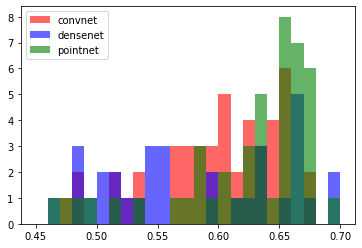

False 4
convnet, N = 8, mean performance: 0.518728320642978
densenet, N = 5, mean performance: 0.488433135927806
pointnet, N = 2, mean performance: 0.4751170332769318

False 30
convnet, N = 18, mean performance: 0.6337273061979068
densenet, N = 10, mean performance: 0.5503581359278059
pointnet, N = 9, mean performance: 0.6236244594848656

True 4
convnet, N = 7, mean performance: 0.5863815163967449
densenet, N = 5, mean performance: 0.5743946700507614
pointnet, N = 12, mean performance: 0.5943506180673058

True 30
convnet, N = 12, mean performance: 0.6116889570407972
densenet, N = 12, mean performance: 0.6577525850723821
pointnet, N = 22, mean performance: 0.6496362226324156



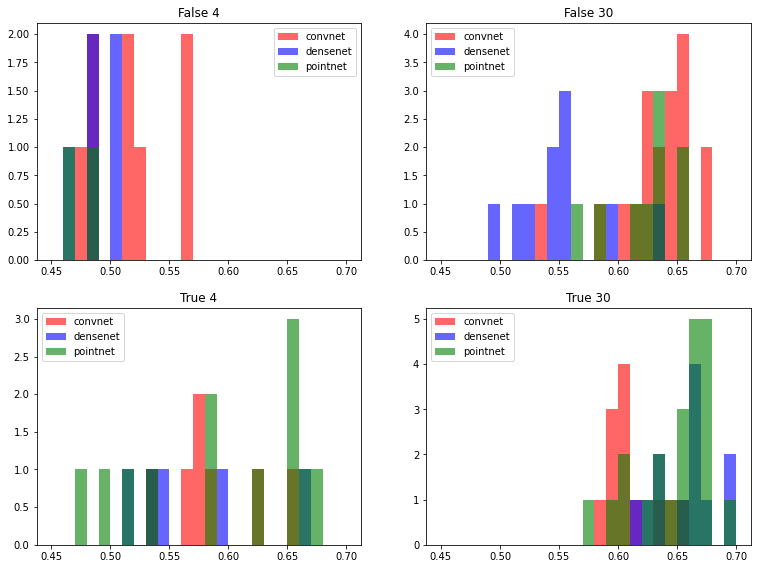

In [36]:
performance_histogram(backbones, foldlabels, dimensions, filters=['backbone_name', 'foldlabel', 'num_representation_features'])

False, N = 60, mean performance: 0.575194686501222
True, N = 71, mean performance: 0.6226564885647784


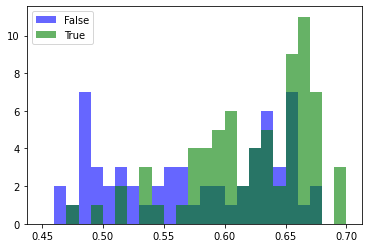

4 convnet
False, N = 8, mean performance: 0.518728320642978
True, N = 7, mean performance: 0.5863815163967449

4 densenet
False, N = 5, mean performance: 0.488433135927806
True, N = 5, mean performance: 0.5743946700507614

4 pointnet
False, N = 2, mean performance: 0.4751170332769318
True, N = 12, mean performance: 0.5943506180673058

30 convnet
False, N = 18, mean performance: 0.6337273061979068
True, N = 12, mean performance: 0.6116889570407972

30 densenet
False, N = 10, mean performance: 0.5503581359278059
True, N = 12, mean performance: 0.6577525850723821

30 pointnet
False, N = 9, mean performance: 0.6236244594848656
True, N = 22, mean performance: 0.6496362226324156



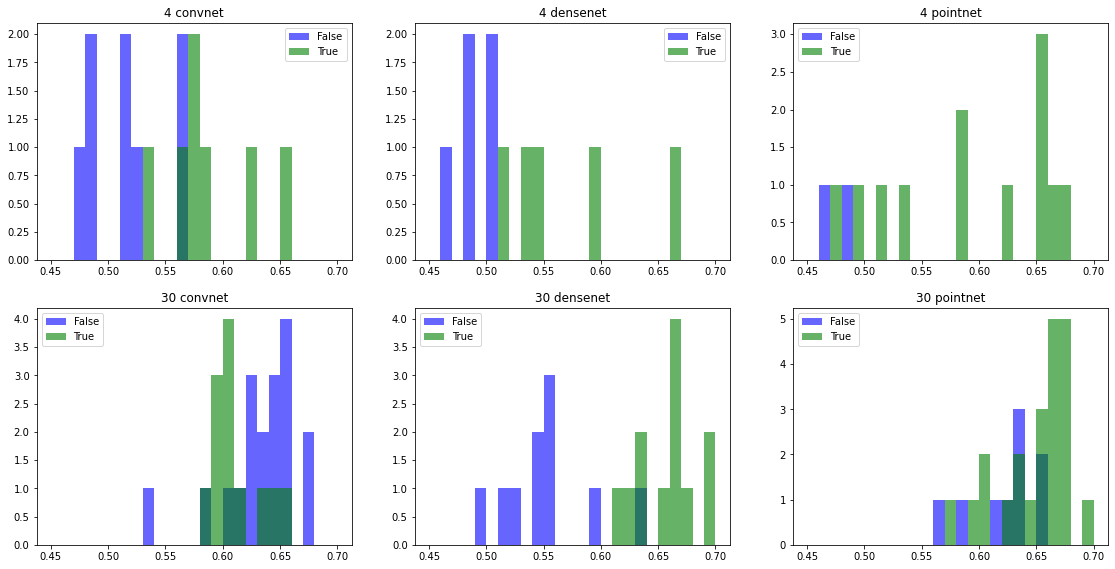

In [37]:
performance_histogram(foldlabels, dimensions, backbones, filters=['foldlabel', 'num_representation_features', 'backbone_name'],
                      colors=['b', 'g'])

4, N = 42, mean performance: 0.5524587798458357
30, N = 86, mean performance: 0.6254593498734243


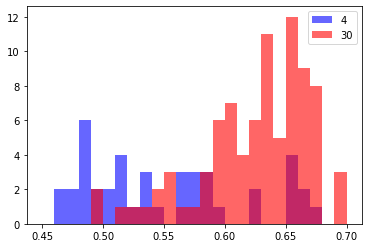

False convnet
4, N = 8, mean performance: 0.518728320642978
30, N = 18, mean performance: 0.6337273061979068

False densenet
4, N = 5, mean performance: 0.488433135927806
30, N = 10, mean performance: 0.5503581359278059

False pointnet
4, N = 2, mean performance: 0.4751170332769318
30, N = 9, mean performance: 0.6236244594848656

True convnet
4, N = 7, mean performance: 0.5863815163967449
30, N = 12, mean performance: 0.6116889570407972

True densenet
4, N = 5, mean performance: 0.5743946700507614
30, N = 12, mean performance: 0.6577525850723821

True pointnet
4, N = 12, mean performance: 0.5943506180673058
30, N = 22, mean performance: 0.6496362226324156



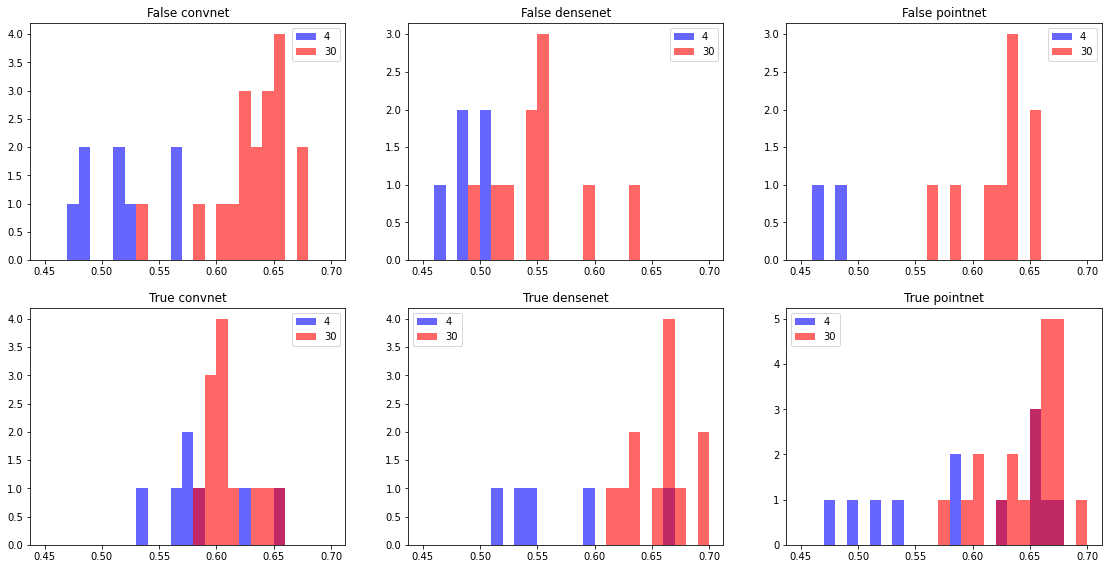

In [38]:
performance_histogram(dimensions, foldlabels, backbones, filters=['num_representation_features', 'foldlabel', 'backbone_name'],
                      colors=['b', 'r'])

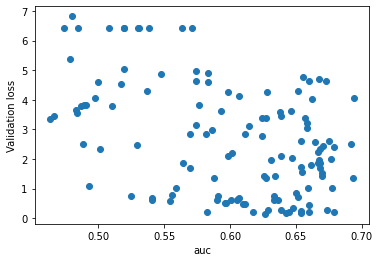

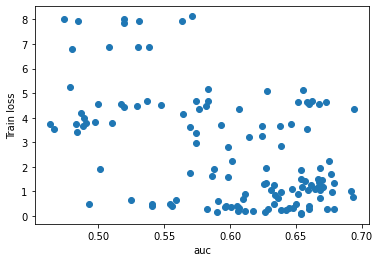

In [66]:
plt.scatter(bdd.auc, bdd.val_loss)
plt.xlabel('auc')
plt.ylabel('Validation loss')

plt.figure()
plt.scatter(bdd.auc, bdd.train_loss)
plt.xlabel('auc')
plt.ylabel('Train loss')

plt.show()

In [67]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]

df = pd.DataFrame(np.zeros((3,2)), columns=foldlabels, index=backbones)

for backbone in backbones:
    for foldlabel in foldlabels:
        filtered_bdd = bdd[(bdd.backbone_name == backbone) & (bdd.foldlabel == foldlabel)]
        df[foldlabel][backbone] = filtered_bdd.auc.mean()

df

,False,True
convnet,0.597548,0.602365
densenet,0.527209,0.633236
pointnet,0.588168,0.630124


In [68]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dims = [4, 30]

idx = ['no foldlabel 4', 'no foldlabel 30', 'foldlabel 4', 'foldlabel 30']

df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)
count_df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones, dtype=int)

for backbone in backbones:
    i = 0
    for foldlabel in foldlabels:
        for dim in dims:
            filtered_bdd = bdd[(bdd.backbone_name == backbone) & (bdd.foldlabel == foldlabel) & (bdd.num_representation_features == dim)]
            df[backbone][i] = filtered_bdd.auc.mean()
            count_df[backbone][i] =  filtered_bdd.count()[0]
            i+=1

df

,convnet,densenet,pointnet
no foldlabel 4,0.518728,0.488433,0.475117
no foldlabel 30,0.633727,0.550358,0.620468
foldlabel 4,0.586382,0.574395,0.594351
foldlabel 30,0.611689,0.657753,0.649636


In [69]:
count_df

,convnet,densenet,pointnet
no foldlabel 4,8,5,2
no foldlabel 30,18,10,7
foldlabel 4,7,5,12
foldlabel 30,12,12,22


### Pointnet focus

In [67]:
pointnets = bdd[(bdd.backbone_name == 'pointnet')]
pointnets = pointnets[interesting_columns]
pointnets

,model_path,auc,auc_std,backbone_name,batch_size,dataset_name,drop_rate,foldlabel,num_representation_features,temperature
81,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.50
89,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.678702,0.006920,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
84,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.677713,0.000947,pointnet,16,cingulate_HCP_half_1,0.00,True,30,0.10
78,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.674897,0.015476,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.10
70,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.672935,0.013104,pointnet,16,cingulate_HCP_full,0.05,True,4,0.50
85,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.670079,0.008259,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
88,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.669777,0.006462,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
79,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.668236,0.018538,pointnet,16,cingulate_HCP_half_1,0.15,True,30,0.10
86,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.667489,0.007258,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10
90,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.666463,0.007006,pointnet,16,cingulate_HCP_half_1,0.05,True,30,0.10


In [54]:
# consistency analysis
# take models with the same parameters and compare the performance

params = ['backbone_name', 'batch_size', 'drop_rate', 'early_stopping_patience',
        'foldlabel', 'input_size', 'lr', 'max_angle', 'max_epochs',
        'num_outputs', 'num_representation_features', 'numpy_all',
        'temperature', 'temperature_initial', 'git_branch']

df = bdd[params]

bdd[df.duplicated(keep=False) & (bdd.backbone_name == 'pointnet')]


,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,input_size,lr,max_angle,max_epochs,num_outputs,num_representation_features,numpy_all,temperature,temperature_initial,git_branch
71,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,0.669267,0.009264,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.5,0.5,pointnet
68,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.674897,0.015476,0.641771,0.015699,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet
69,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.668236,0.018538,0.655707,0.015699,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet
82,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.614146,0.015697,0.604997,0.017516,pointnet,16,0.15,100,False,"(1, 17, 40, 38)",0.0004,10,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet
72,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.606891,0.013846,0.607930,0.012928,pointnet,16,0.15,100,True,"(1, 17, 40, 38)",0.0004,6,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.5,0.5,pointnet
81,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.588038,0.032487,0.583425,0.027912,pointnet,16,0.15,100,False,"(1, 17, 40, 38)",0.0004,10,250,30,30,/neurospin/dico/data/deep_folding/current/data...,0.1,0.1,pointnet


In [76]:
bad_models = bdd[bdd.auc <= 0.55]

print("proportion 4 parmi les mauvais modèles :", bad_models[bad_models.num_representation_features == 4].shape[0]/bad_models.shape[0])
print("proportion 4 parmi les modèles :", bdd[bdd.num_representation_features == 4].shape[0]/bdd.shape[0])

bad_models

proportion 4 parmi les mauvais modèles : 0.7931034482758621
proportion 4 parmi les modèles : 0.3853211009174312


,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,max_angle,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,dataset_name,git_branch
27,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.547569,0.057362,0.539683,0.044184,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,4.531240,4.867878,cingulate_HCP_half_1,Run_03_aymeric
34,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.540923,0.033724,0.539085,0.029719,densenet,16,0.15,100,False,...,10,250,30,30,0.1,0.1,0.491312,0.603156,cingulate_HCP_half_1,Run_03_aymeric
30,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.538566,0.027027,0.577713,0.000000,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,6.863671,6.433455,cingulate_HCP_half_1,Run_03_aymeric
76,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.536983,0.005141,0.544880,0.003870,pointnet,16,0.05,100,True,...,6,250,4,4,0.5,0.5,4.673968,4.301939,cingulate_HCP_half_1,pointnet
8,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.530707,0.044796,0.506229,0.049234,convnet,16,0.15,250,True,...,6,250,4,4,0.1,0.1,7.934582,6.433455,cingulate_HCP_half_1,Run_03_aymeric
57,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.530619,0.044917,0.518217,0.051808,convnet,16,0.60,100,False,...,10,250,30,30,0.1,0.1,6.863864,6.437438,cingulate_HCP_half_1,Run_03_aymeric
21,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.529559,0.046242,0.530170,0.036701,convnet,16,0.15,250,False,...,10,250,4,4,0.1,0.1,4.490583,2.484959,cingulate_HCP_half_1,Run_03_aymeric
29,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519898,0.052222,0.517889,0.044333,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,4.442244,5.053896,cingulate_HCP_half_1,Run_03_aymeric
18,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519531,0.036233,0.508657,0.047433,convnet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,8.032898,6.433870,cingulate_HCP_half_1,Run_03_aymeric
16,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519293,0.042167,0.507683,0.046822,convnet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,7.847290,6.433280,cingulate_HCP_half_1,Run_03_aymeric


### Compare full HCP and half HCP

In [84]:
# first batch

hcp_full = bdd[(bdd.dataset_name == 'cingulate_HCP_full') & (bdd.num_representation_features == 30)]
hcp_half = bdd[(bdd.dataset_name != 'cingulate_HCP_full') & (bdd.num_representation_features == 30) & (bdd.drop_rate == 0.05) & (bdd.foldlabel == True)]

print("Full:", hcp_full.auc.mean(), "Half:", hcp_half.auc.mean())

Full: 0.6439337281443881 Half: 0.6676759259259258


In [85]:
# second batch

hcp_full = bdd[(bdd.dataset_name == 'cingulate_HCP_full') & (bdd.num_representation_features == 4)]
hcp_half = bdd[(bdd.dataset_name != 'cingulate_HCP_full') & (bdd.num_representation_features == 4) & (bdd.drop_rate == 0.05) & (bdd.foldlabel == True)]

print("Full:", hcp_full.auc.mean(), "Half:", hcp_half.auc.mean())

Full: 0.5866613931190072 Half: 0.5914255499153975


Full HCP isn't worth it